In [1]:
import glob
import re

INPUT_FOLDER = '../../../travelogues-corpus/16th_century/books'

def read_file(f):
  with open(f, 'r') as file:
    str = file.read()
    ascii_only = re.sub('[^A-Za-z0-9 ]+', '', str)
    return re.sub('\\s+', ' ', ascii_only)

filenames = [f for f in glob.glob(INPUT_FOLDER + '**/*.txt')]
texts = [ read_file(f) for f in filenames ]

f'Loaded {len(texts)} documents'

'Loaded 66 documents'

In [2]:
extra_stopwords = []

with open('stopwords.txt') as f:
  extra_stopwords = f.readlines()
  extra_stopwords = [ x.strip() for x in extra_stopwords ]

In [3]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words = stopwords.words('german')
stop_words.extend(extra_stopwords)
stop_words.sort()

[nltk_data] Downloading package stopwords to /home/simonr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import itertools
import matplotlib.pyplot as plt
import string

# We'll do stemming to avoid duplicate variants
porter = PorterStemmer()

def stem_message(text):
  words = word_tokenize(text)

  stemmed_words = []
  for word in words:
    stemmed_words.append(porter.stem(word))
    
  # Remove stopwords here
  clean_tokens = [w for w in stemmed_words if not w in stop_words and len(w) > 3] 
  return ' '.join(clean_tokens)

cleaned_texts = []
for text in texts:
  # Remove punctutation
  text = text.translate(str.maketrans('', '', string.punctuation))
  cleaned_texts.append(stem_message(text))

In [5]:
import string
import gensim

training_data = [ gensim.models.doc2vec.TaggedDocument(txt.split(), [ i ]) for i, txt in enumerate(cleaned_texts) ]

model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)
model.build_vocab(training_data)
model.train(training_data, total_examples=model.corpus_count, epochs=model.epochs)

In [12]:
from sklearn.cluster import KMeans
import numpy as np

vectors = [ model.docvecs[idx] for idx in range(0, len(texts)) ]

CLUSTER_NUM = 20

km = KMeans(
  n_clusters=CLUSTER_NUM, init='random',
  n_init=10, max_iter=300, 
  tol=1e-04, random_state=0)

km_10_clusters = km.fit_predict(vectors)

In [13]:
from sklearn.manifold import TSNE

tsne_model_2d = TSNE(perplexity=4, n_components=2, init='pca', n_iter=4000, random_state=32)
embeddings_2d = tsne_model_2d.fit_transform(np.array(vectors))

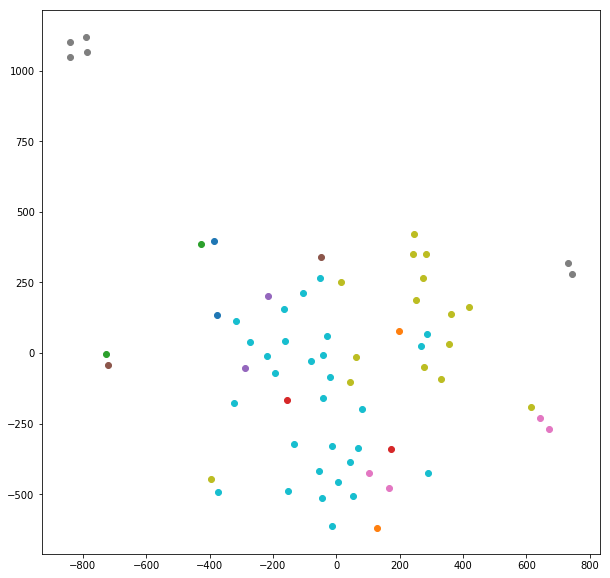

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.tab10(np.linspace(0, 1, CLUSTER_NUM))

clusters = [ embeddings_2d[km_10_clusters == idx] for idx in range(CLUSTER_NUM) ]
clusters = sorted(clusters, key=len)

fig = plt.figure(figsize=(10, 10))

for idx, c in enumerate(clusters):
  x = c[:, 0]
  y = c[:, 1]
  plt.scatter(x, y, s=36, color=colors[idx])

plt.show()

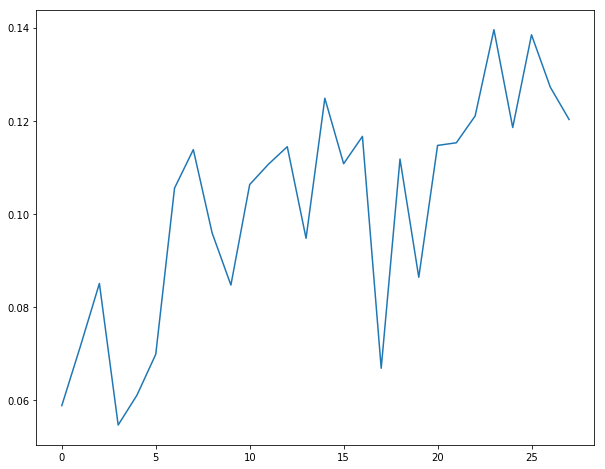

In [15]:
from sklearn.metrics import silhouette_score

sil = []
k_max = 30

for k in range(2, k_max):
  kmeans = KMeans(n_clusters = k).fit(vectors)
  labels = kmeans.labels_
  sil.append(silhouette_score(vectors, labels, metric = 'euclidean'))

plt.figure(figsize=(10, 8))
plt.plot(sil)
plt.show()

In [16]:
clustered_filenames = [ np.array(filenames)[km_10_clusters == idx] for idx in range(CLUSTER_NUM) ]

def to_barcode(filename):
  return filename[filename.rindex('/') + 1: -4]

clustered_urls = map(lambda cluster: [ f'http://data.onb.ac.at/ABO/+{to_barcode(f)}' for f in cluster ] , clustered_filenames)
list(clustered_urls)

[['http://data.onb.ac.at/ABO/+Z159588009',
  'http://data.onb.ac.at/ABO/+Z175034204',
  'http://data.onb.ac.at/ABO/+Z168091302',
  'http://data.onb.ac.at/ABO/+Z184140306'],
 ['http://data.onb.ac.at/ABO/+Z178362103',
  'http://data.onb.ac.at/ABO/+Z157711400'],
 ['http://data.onb.ac.at/ABO/+Z256471804',
  'http://data.onb.ac.at/ABO/+Z157598504',
  'http://data.onb.ac.at/ABO/+Z180631800',
  'http://data.onb.ac.at/ABO/+Z35076705',
  'http://data.onb.ac.at/ABO/+Z156577207',
  'http://data.onb.ac.at/ABO/+Z157583008',
  'http://data.onb.ac.at/ABO/+Z15657730X',
  'http://data.onb.ac.at/ABO/+Z169010905',
  'http://data.onb.ac.at/ABO/+Z186388101',
  'http://data.onb.ac.at/ABO/+Z224214403',
  'http://data.onb.ac.at/ABO/+Z164752105',
  'http://data.onb.ac.at/ABO/+Z156265702'],
 ['http://data.onb.ac.at/ABO/+Z185142207',
  'http://data.onb.ac.at/ABO/+Z165780108'],
 ['http://data.onb.ac.at/ABO/+Z159579604'],
 ['http://data.onb.ac.at/ABO/+Z163300909',
  'http://data.onb.ac.at/ABO/+Z253367704',
  'http